In [1]:
from esfMRI import plot_sates, stats_tests
from statsmodels.stats import nonparametric
from nilearn import plotting, datasets
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import numpy as np
import pickle
import json
import os
from graph import cal_graph

In [2]:
# 可调节参数
# Adjustable parameters
window_length = 60 # 窗口尺寸，单位s
sliding_step = 1 # 滑动步长，单位TR
target_states = [2, 3, 4] # 目标状态数
np.set_printoptions(formatter={"all":lambda x: f" {x:0>0.2f} "})
plt.rcParams['font.family']=['Times New Roman']
fontsize = 18
plt.rcParams['font.size']=fontsize
plt.rcParams['xtick.labelsize']=fontsize
plt.rcParams['ytick.labelsize']=fontsize
plt.rcParams['axes.labelsize']=fontsize
bg_color = None
fig_format = "png"

In [11]:
# 加载slidingWindow.ipynb中获取的动态功能连接数据
# load pickle data generated in slidingWindow.ipynb
with open(f"dFC/{window_length}_{sliding_step}dFCs.pkl", "rb") as f:
    dFCs = pickle.load(f)

In [ ]:
# 绘制状态变化，保存状态变化对象
# plot states changing, and then save
pkl_dir = "states/total"
os.makedirs(f"{pkl_dir}/pkl", exist_ok=True)
for k in target_states:
    with open(f"{pkl_dir}/cluster/km_{window_length}s_{k}states.pkl", "rb") as f:
        km = pickle.load(f)
    states = {}
    for subid in dFCs:
        states[subid] = {}
        save_dir = f"states/total/{k}states/{window_length}/{subid}"
        os.makedirs(save_dir, exist_ok=True)
        states[subid]["ses-preop"] = {}
        for run, items in dFCs[subid]["ses-preop"].items():
            # if run == "total":
            #     continue
            states[subid]["ses-preop"][run] = km.predict(items.reshape((items.shape[0], 13456)))
            plot_sates(states[subid]["ses-preop"][run], k, f"{save_dir}/preop_{run}.png")
        states[subid]["ses-postop"] = {}
        for run, items in dFCs[subid]["ses-postop"].items():
            # if run == "total":
            #     continue
            states[subid]["ses-postop"][run] = km.predict(items.reshape((items.shape[0], 13456)))
            plot_sates(states[subid]["ses-postop"][run], k, f"{save_dir}/postop{run}.png")
    with open(f"{pkl_dir}/pkl/{window_length}s_{k}states.pkl", "wb") as f:
        pickle.dump(states, f)

In [ ]:
# 计算并保存状态中心的图论参数
with open(f"{pkl_dir}/cluster/km_60s_2states.pkl", "rb") as f:
    km = pickle.load(f)
fcgs = []
for i, state in enumerate(km.cluster_centers_):
    threshold = state.max()/2
    fcgs.append(cal_graph(state, threshold))
with open("states/total/fcgs.pkl", "wb") as f:
    pickle.dump(fcgs, f)

为每个簇中的电刺激前后dFC分别求质心，对比质心差异

In [25]:
window_length = 60
k = 2
with open(f"states/total/cluster/km_{window_length}s_{k}states.pkl", "rb") as f:
    km = pickle.load(f)
with open(f"states/total/pkl/{window_length}s_{k}states.pkl", "rb") as f:
    states = pickle.load(f)
with open(f"dFC/{window_length}_1dFCs.pkl", "rb") as f:
    dFCs = pickle.load(f)

c:\Users\12500\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator KMeans from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [26]:
for sub in states:
    cnt_preop = np.zeros((k,))
    cnt_postop = np.zeros((k,))
    for run in states[sub]["ses-preop"]:
        for state, fc in zip(states[sub]["ses-preop"][run], dFCs[sub]["ses-preop"][run]):
            cnt_preop[state] += 1
    for run in states[sub]["ses-postop"]:
        for state, fc in zip(states[sub]["ses-postop"][run], dFCs[sub]["ses-postop"][run]):
            cnt_postop[state] += 1
    print(sub, cnt_preop, cnt_postop)

sub-292 [ 274.00   25.00 ] [ 77.00   1089.00 ]
sub-294 [ 256.00   74.00 ] [ 113.00   310.00 ]
sub-302 [ 135.00   134.00 ] [ 109.00   315.00 ]
sub-303 [ 0.00   412.00 ] [ 0.00   1059.00 ]
sub-307 [ 411.00   1.00 ] [ 538.00   792.00 ]
sub-314 [ 197.00   215.00 ] [ 155.00   830.00 ]
sub-316 [ 228.00   287.00 ] [ 225.00   1035.00 ]
sub-320 [ 0.00   103.00 ] [ 34.00   1234.00 ]
sub-330 [ 103.00   0.00 ] [ 332.00   1339.00 ]
sub-331 [ 174.00   32.00 ] [ 402.00   1506.00 ]
sub-334 [ 14.00   398.00 ] [ 48.00   1962.00 ]
sub-335 [ 267.00   42.00 ] [ 555.00   1564.00 ]
sub-352 [ 0.00   206.00 ] [ 23.00   1541.00 ]
sub-372 [ 248.00   61.00 ] [ 407.00   1000.00 ]
sub-376 [ 212.00   97.00 ] [ 213.00   789.00 ]
sub-384 [ 38.00   271.00 ] [ 21.00   779.00 ]
sub-399 [ 124.00   185.00 ] [ 352.00   1246.00 ]
sub-400 [ 193.00   116.00 ] [ 55.00   945.00 ]
sub-405 [ 481.00   34.00 ] [ 307.00   893.00 ]
sub-413 [ 483.00   32.00 ] [ 67.00   533.00 ]


In [27]:
dFC_preop = np.zeros((k, 116, 116))
dFC_postop = np.zeros((k, 116, 116))
cnt_preop = np.zeros((k,))
cnt_postop = np.zeros((k,))
for sub in states:
    for run in states[sub]["ses-preop"]:
        for state, fc in zip(states[sub]["ses-preop"][run], dFCs[sub]["ses-preop"][run]):
            dFC_preop[state] += fc
            cnt_preop[state] += 1
    for run in states[sub]["ses-postop"]:
        for state, fc in zip(states[sub]["ses-postop"][run], dFCs[sub]["ses-postop"][run]):
            dFC_postop[state] += fc
            cnt_postop[state] += 1
centroids_preop = np.array([dFC_preop[0]/cnt_preop[0], dFC_preop[1]/cnt_preop[1]])
centroids_postop = np.array([dFC_postop[0]/cnt_postop[0], dFC_postop[1]/cnt_postop[1]])
save_dir = "states/total/centroids"
os.makedirs(save_dir, exist_ok=True)
with open(f"{save_dir}/centroids_preop.pkl", "wb") as f:
    pickle.dump(centroids_preop, f)
with open(f"{save_dir}/centroids_postop.pkl", "wb") as f:
    pickle.dump(centroids_postop, f)

In [15]:
window_length = 60
k = 2
with open(f"states/total/cluster/km_{window_length}s_{k}states.pkl", "rb") as f:
    km = pickle.load(f)
save_dir = "states/total/centroids"
with open(f"{save_dir}/centroids_preop.pkl", "rb") as f:
    centroids_preop = pickle.load(f)
with open(f"{save_dir}/centroids_postop.pkl", "rb") as f:
    centroids_postop = pickle.load(f)
centroids_change = centroids_postop - centroids_preop
for i, fc in enumerate(centroids_preop):
    np.fill_diagonal(fc, 0)
for i, fc in enumerate(centroids_postop):
    np.fill_diagonal(fc, 0)

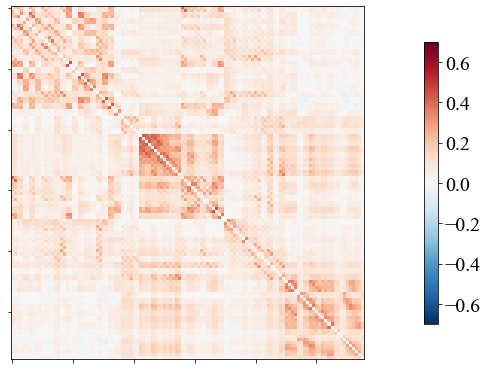

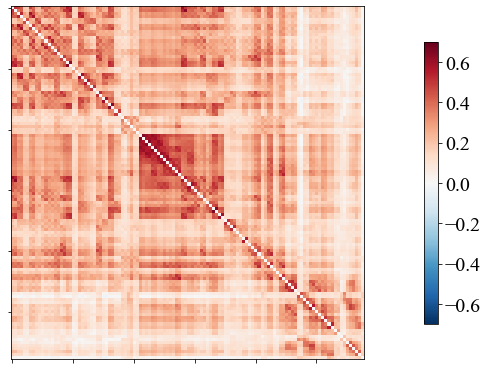

In [16]:
# 聚类中心
for i, state in enumerate(km.cluster_centers_):
    fc = state.reshape((116, 116))
    np.fill_diagonal(fc, 0)
    fc_display = plotting.plot_matrix(fc, colorbar=True, vmax=0.7, vmin=-0.7)
    fc_display.colorbar.ax.tick_params(labelsize=fontsize+2)
    fig_fc, ax_fc = fc_display.figure, fc_display.axes
    if bg_color:
        fig_fc.patch.set_color(bg_color)
    fig_fc.savefig(f"{save_dir}/center_{i}.{fig_format}", format=fig_format, bbox_inches = 'tight')

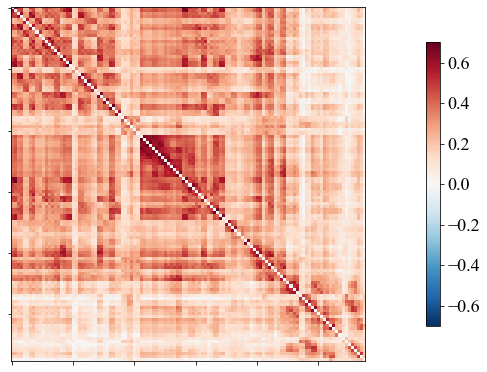

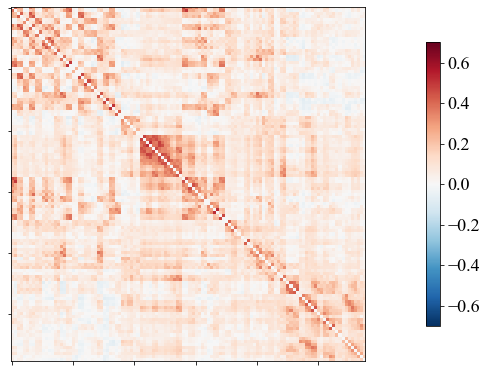

In [30]:
# 电刺激前质心
for i, fc in enumerate(centroids_preop):
    np.fill_diagonal(fc, 0)
    fc_display = plotting.plot_matrix(fc, colorbar=True, vmax=0.7, vmin=-0.7)
    fc_display.colorbar.ax.tick_params(labelsize=fontsize)
    fig_fc, ax_fc = fc_display.figure, fc_display.axes
    if bg_color:
        fig_fc.patch.set_color(bg_color)
    fig_fc.savefig(f"{save_dir}/preop_{i}.{fig_format}", format=fig_format, bbox_inches = 'tight')

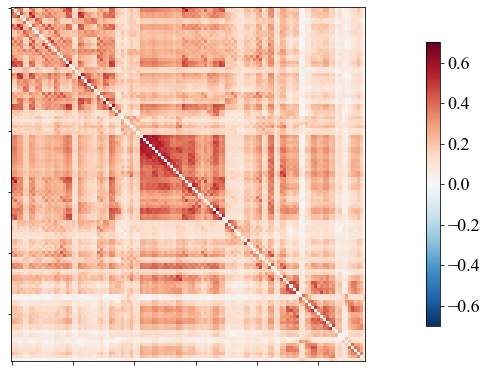

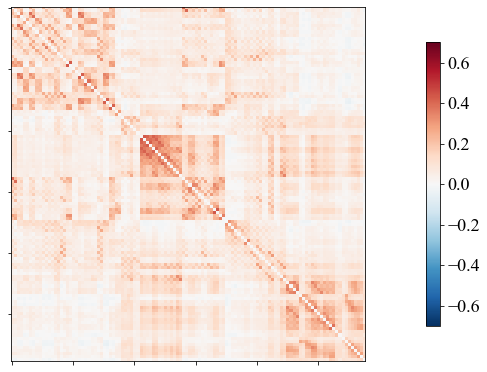

In [31]:
# 电刺激后质心
for i, fc in enumerate(centroids_postop):
    np.fill_diagonal(fc, 0)
    fc_display = plotting.plot_matrix(fc, colorbar=True, vmax=0.7, vmin=-0.7)
    fc_display.colorbar.ax.tick_params(labelsize=fontsize)
    fig_fc, ax_fc = fc_display.figure, fc_display.axes
    if bg_color:
        fig_fc.patch.set_color(bg_color)
    fig_fc.savefig(f"{save_dir}/postop_{i}.{fig_format}", format=fig_format, bbox_inches = 'tight')

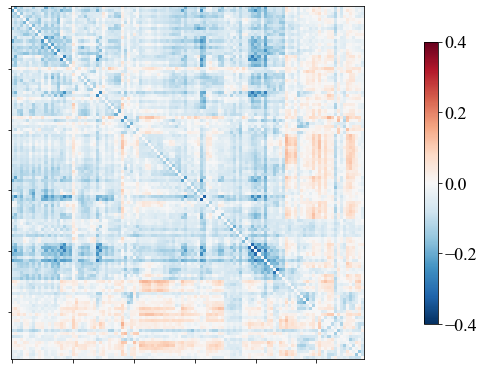

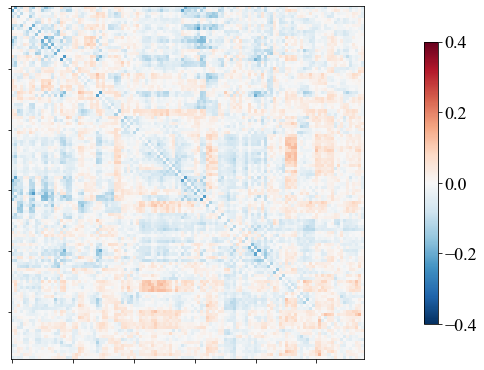

In [17]:
# 电刺激前后变化
for i, fc in enumerate(centroids_change):
    np.fill_diagonal(fc, 0)
    fc_display = plotting.plot_matrix(fc, colorbar=True, vmax=0.4, vmin=-0.4)
    fc_display.colorbar.ax.tick_params(labelsize=fontsize)
    fig_fc, ax_fc = fc_display.figure, fc_display.axes
    if bg_color:
        fig_fc.patch.set_color(bg_color)
    fig_fc.savefig(f"{save_dir}/change_{i}.{fig_format}", format=fig_format, bbox_inches = 'tight')

In [18]:
atlas = datasets.fetch_atlas_aal()
atlas_labels = atlas['labels']
coords = plotting.find_parcellation_cut_coords(atlas["maps"])

In [19]:
node_size = 20
edge_threshold = "95%"

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
for i, fc in enumerate(centroids_change):
    plotting.plot_connectome(fc, coords, figure=fig, axes=axs[i], node_size=node_size, edge_threshold=edge_threshold, output_file=f"{save_dir}/connectome.png", colorbar=True)
fig.savefig(f"{save_dir}/connectome.png", dpi=600)

In [74]:
import pandas as pd
for i, fc in enumerate(centroids_change):
    # fc = np.vstack(([0]+atlas_labels, np.hstack((np.array(atlas_labels).reshape((116,1)), fc))))
    # np.savetxt(f"{save_dir}/centroids_change_{i}.txt", fc)
    fc = pd.DataFrame(fc, columns=atlas_labels, index=atlas_labels)
    fc.to_csv(f"{save_dir}/centroids_change_{i}.csv", "\t")

### 基于状态的方法的动态指标(state-based):

**dFC强度（dFC strength）**：FC在给定状态中的强度。  
**停留时间（Dwell time）**：受试在每个状态中停留的平均时间。  
**占用率（Occupancy rate）**：扫描期间每个状态发生的时间百分比。  
**转换概率矩阵（Transition matrix）**：从一种状态转换到另一种状态的概率。（可同时分析下转移次数的差异）  
**平均可变性指数（Average variability index）**：它表示功能源的整体动态水平。可变性指数定义为二项分布的标准差，并估计一个区域与给定源的关联中的可变性水平。  
**功能（域间）状态连接（Functional (inter-domain) state connectivity）**：当一种技术（例如空间动态层次）分别估计每个源的动态状态时，它可以捕捉不同源（例如功能域）状态之间的并发性。  

In [16]:
window_length = 60
k = 2

In [63]:
# 加载KMeans对象、上文创建的状态变化对象、数据集json
# load KMeans object, states objects created by code cell above, josn file of datasets.
with open(f"states/total/cluster/km_{window_length}s_{k}states.pkl", "rb") as f:
    km = pickle.load(f)
with open(f"states/total/pkl/{window_length}s_{k}states.pkl", "rb") as f:
    states = pickle.load(f)
with open("datasets.json", "rb") as f:
    datasets = json.load(f)

save_dir = "states/total/centroids"
with open(f"{save_dir}/centroids_preop.pkl", "rb") as f:
    centroids_preop = pickle.load(f)
with open(f"{save_dir}/centroids_postop.pkl", "rb") as f:
    centroids_postop = pickle.load(f)
fig_dir = "states/total/figs"

c:\Users\12500\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator KMeans from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [18]:
# dFC强度
# dFC strength
# print(km.cluster_centers_.sum(axis=1)/(116*116))
center = km.cluster_centers_.reshape((km.cluster_centers_.shape[0], 116, 116))
for fc in center:
    np.fill_diagonal(fc, 0)
print(center.sum(axis=(1,2))/(116*116))
# del center
print(centroids_preop.sum(axis=(1,2))/(116*116))
print(centroids_postop.sum(axis=(1,2))/(116*116))

[ 0.21   0.08 ]
[ 0.24   0.10 ]
[ 0.20   0.09 ]


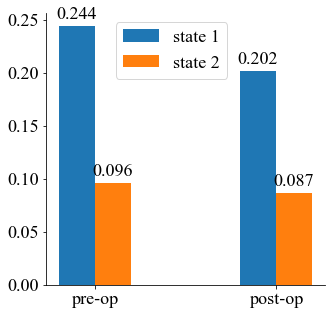

In [61]:
dfc_strength = np.vstack((centroids_preop.sum(axis=(1,2))/(116*116), centroids_postop.sum(axis=(1,2))/(116*116)))
dfc_strength = np.round(dfc_strength, 3)
fig, ax = plt.subplots(figsize=(5, 5))
x = np.arange(2)
bar_width = 0.2
offset = bar_width/2
rects = ax.bar(x + offset, dfc_strength[..., 0], width=bar_width, label = "state 1")
ax.bar_label(rects, padding=3, fontsize=fontsize)
rects = ax.bar(x + offset+bar_width, dfc_strength[..., 1], width=bar_width, label = "state 2")
ax.bar_label(rects, padding=3, fontsize=fontsize)
ax.set_xticks(x + bar_width, ["pre-op", "post-op"], fontsize=fontsize)
ax.legend(loc='upper center', prop = {'size':18}, bbox_to_anchor=(0.45, 1), ncol=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(f"{fig_dir}/dFC_strength.{fig_format}", dpi=300, format=fig_format, bbox_inches = "tight")

In [ ]:
# 状态转换概率
# calculate transition matrix
states_trans_preop = np.zeros(len(states))
states_trans_postop = np.zeros(len(states))
for sub in states:
    for run, state in states[sub]["ses-preop"].items():
        lastState= state[0]
        for st in state:
            if st != lastState:
                states_trans_preop[lastState][st] += 1
                lastState = st
    for run, state in states[sub]["ses-postop"].items():
        lastState= state[0]
        for st in state:
            if st != lastState:
                states_trans_postop[lastState][st] += 1
                lastState = st
transition_matrix_preop = (states_trans_preop.T/states_trans_preop.sum(axis=1)).T
transition_matrix_postop = (states_trans_postop.T/states_trans_postop.sum(axis=1)).T
print("transition times preop: ")
print(states_trans_preop)
print("transition times postop: ")
print(states_trans_postop)
print("transition matrix preop: ")
print(transition_matrix_preop)
print("transition matrix postop: ")
print(transition_matrix_postop)

In [64]:
length_preop = 0
length_postop = 0
states_trans_preop = np.zeros(len(states))
states_trans_postop = np.zeros((len(states)))
states_trans = np.zeros(((len(states)), 2))
i = 0
for sub in states:
    length = 0
    for run, state in states[sub]["ses-preop"].items():
        length += datasets[sub]["ses-preop"][run]["length"]
        lastState= state[0]
        for st in state:
            if st != lastState:
                states_trans_preop[i] += 1
                lastState = st
    states_trans[i][0] = states_trans_preop[i]/(length/300)
    length = 0
    for run, state in states[sub]["ses-postop"].items():
        length += datasets[sub]["ses-postop"][run]["length"]
        lastState= state[0]
        for st in state:
            if st != lastState:
                states_trans_postop[i] += 1
                lastState = st
    states_trans[i][1] = states_trans_postop[i]/(length/300)
    i += 1
states_trans = np.ceil(states_trans)

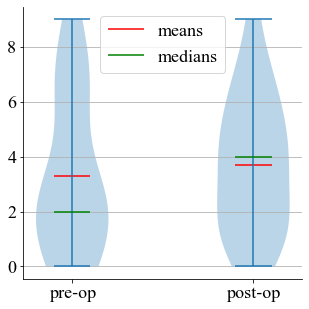

In [65]:
# 转换次数箱线图
fig, ax = plt.subplots(figsize=(5, 5))
# ax.boxplot(dwell_time)
r = ax.violinplot(states_trans, widths=0.4, showmeans=True, showmedians=True)
r['cmeans'].set_color('red')
r['cmeans'].set_label('means')
r['cmedians'].set_color('green')
r['cmedians'].set_label('medians')
ax.yaxis.grid(True)
ax.set_xticks([y + 1 for y in range(states_trans.shape[1])], labels=["pre-op", "post-op"])
ax.legend(loc='upper center')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(f"{fig_dir}/transition.{fig_format}", dpi=300, format=fig_format, bbox_inches = "tight")

In [24]:
# 停留时间，s
# dwell time,s
dwell_time_preop = []
dwell_time_postop = []
for sub in states:
    if sub == "sub-303":
        continue
    # 停留窗口数
    dt_preop = np.zeros(k)
    # 出现次数
    appear_times = np.zeros(k)
    for run, state in states[sub]["ses-preop"].items():
        lastState= -1
        for st in state:
            dt_preop[st] += 1
            if st != lastState:
                appear_times[st] += 1
                lastState = st
    dt_preop = np.divide(dt_preop, appear_times, out=np.zeros_like(dt_preop), where=appear_times!=0)
    dt_preop = dt_preop*datasets[sub]["ses-preop"]["run-01"]["TR"]
    dwell_time_preop.append(dt_preop)
    # 停留窗口数 
    dt_postop = np.zeros(k)
    appear_times = np.zeros(k)
    for run, state in states[sub]["ses-postop"].items():
        lastState= -1
        for st in state:
            dt_postop[st] += 1
            if st != lastState:
                appear_times[st] += 1
                lastState = st
    dt_postop = np.divide(dt_postop, appear_times, out=np.zeros_like(dt_postop), where=appear_times!=0)
    dt_postop *= datasets[sub]["ses-postop"]["run-01"]["TR"]
    dwell_time_postop.append(dt_postop)
    # print(sub, f"preop: {dt_preop[0]:6.2f} {dt_preop[1]:6.2f} {dt_preop[2]:6.2f}, ", f"postop: {dt_postop[0]:6.2f} {dt_postop[1]:6.2f} {dt_postop[2]:6.2f}")
    print(sub, f"preop: {dt_preop[0]:6.2f} {dt_preop[1]:6.2f}, ", f"postop: {dt_postop[0]:6.2f} {dt_postop[1]:6.2f}")
dwell_time_preop = np.array(dwell_time_preop)
dwell_time_postop = np.array(dwell_time_postop)

sub-292 preop: 137.00  16.67,  postop:  23.87 259.68
sub-294 preop:  46.55  14.80,  postop:  21.19  54.71
sub-302 preop:  38.57  38.29,  postop:  16.35  45.00
sub-307 preop: 185.77   2.26,  postop:  31.65  44.00
sub-314 preop:  89.04  97.18,  postop:  23.25 108.26
sub-316 preop:  25.76  29.48,  postop:  18.24  73.93
sub-320 preop:   0.00 232.78,  postop:  51.00 462.75
sub-330 preop: 232.78   0.00,  postop:  34.34 121.73
sub-331 preop:  98.31  24.11,  postop:  32.59 112.95
sub-334 preop:  10.55 128.50,  postop:  18.00 327.00
sub-335 preop: 150.85  47.46,  postop:  32.02  86.89
sub-352 preop:   0.00 232.78,  postop:  23.00 355.62
sub-372 preop:  56.05  17.23,  postop:  42.10  96.77
sub-376 preop:  59.89  36.54,  postop:  21.73  73.16
sub-384 preop:  10.73  61.25,  postop:   9.00 233.70
sub-399 preop:  70.06 104.52,  postop:  29.33  93.45
sub-400 preop:  39.65  26.22,  postop:  33.00 283.50
sub-405 preop: 155.29  25.61,  postop:  27.91  74.42
sub-413 preop: 136.45  24.11,  postop:  50.25 

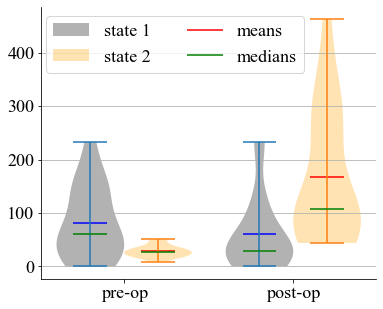

In [66]:
# 持续时间箱线图
dwell_time = np.hstack((dwell_time_preop, dwell_time_postop))
fig, ax = plt.subplots(figsize=(6, 5))
# 分组绘制
x = np.arange(2)
group_width = 0.4
offset = group_width/2
# rects = ax.bar(x + offset+group_width, dfc_strength[..., 1], width=group_width, label = "state 2")
# ax.boxplot(dwell_time)
r = ax.violinplot(dwell_time_preop, positions=x+offset, widths=group_width, showmeans=True, showmedians=True)
for pc in r["bodies"]:
    pc.set_facecolor('black')
pc.set_label('state 1')
r['cmeans'].set_color('blue')
r['cmedians'].set_color('green')
r = ax.violinplot(dwell_time_postop, positions=x+offset+group_width, widths=group_width, showmeans=True, showmedians=True)
for pc in r["bodies"]:
    pc.set_facecolor('orange')
pc.set_label('state 2')
r['cmeans'].set_color('red')
r['cmeans'].set_label('means')
r['cmedians'].set_color('green')
r['cmedians'].set_label('medians')
ax.set_xticks(x + group_width, ["pre-op", "post-op"])
ax.yaxis.grid(True)
# ax.legend(handles=[r['cmeans'], r['cmedians'], r['bodies'][0]], loc='upper center', ncol=2)
ax.legend(loc='upper center', bbox_to_anchor=(0.4, 1), ncol=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(f"{fig_dir}/dwell_time.{fig_format}", dpi=300, format=fig_format, bbox_inches = "tight")

In [26]:
# 占用率
count_preop = []
count_postop = []
occupancy_rate_preop = []
occupancy_rate_postop = []
for sub in states:
    cnt_preop = np.zeros((k,))
    cnt_postop = np.zeros((k,))
    for run in states[sub]["ses-preop"]:
        for state in states[sub]["ses-preop"][run]:
            cnt_preop[state] += 1
    for run in states[sub]["ses-postop"]:
        for state in states[sub]["ses-postop"][run]:
            cnt_postop[state] += 1
    print(f"{sub}: preop: ", cnt_preop/sum(cnt_preop), " postop:", cnt_postop/cnt_postop.sum())
    count_preop.append(cnt_preop)
    count_postop.append(cnt_postop)
    occupancy_rate_preop.append(cnt_preop/sum(cnt_preop))
    occupancy_rate_postop.append(cnt_postop/sum(cnt_postop))
count_preop = np.array(count_preop)
count_postop = np.array(count_postop)
occupancy_rate_preop = np.array(occupancy_rate_preop)
occupancy_rate_postop = np.array(occupancy_rate_postop)
print("total:   preop: ", count_preop.sum(axis=0)/count_preop.sum(), " postop:", count_postop.sum(axis=0)/count_postop.sum())

sub-292: preop:  [ 0.92   0.08 ]  postop: [ 0.07   0.93 ]
sub-294: preop:  [ 0.78   0.22 ]  postop: [ 0.27   0.73 ]
sub-302: preop:  [ 0.50   0.50 ]  postop: [ 0.26   0.74 ]
sub-303: preop:  [ 0.00   1.00 ]  postop: [ 0.00   1.00 ]
sub-307: preop:  [ 1.00   0.00 ]  postop: [ 0.40   0.60 ]
sub-314: preop:  [ 0.48   0.52 ]  postop: [ 0.16   0.84 ]
sub-316: preop:  [ 0.44   0.56 ]  postop: [ 0.18   0.82 ]
sub-320: preop:  [ 0.00   1.00 ]  postop: [ 0.03   0.97 ]
sub-330: preop:  [ 1.00   0.00 ]  postop: [ 0.20   0.80 ]
sub-331: preop:  [ 0.84   0.16 ]  postop: [ 0.21   0.79 ]
sub-334: preop:  [ 0.03   0.97 ]  postop: [ 0.02   0.98 ]
sub-335: preop:  [ 0.86   0.14 ]  postop: [ 0.26   0.74 ]
sub-352: preop:  [ 0.00   1.00 ]  postop: [ 0.01   0.99 ]
sub-372: preop:  [ 0.80   0.20 ]  postop: [ 0.29   0.71 ]
sub-376: preop:  [ 0.69   0.31 ]  postop: [ 0.21   0.79 ]
sub-384: preop:  [ 0.12   0.88 ]  postop: [ 0.03   0.97 ]
sub-399: preop:  [ 0.40   0.60 ]  postop: [ 0.22   0.78 ]
sub-400: preop

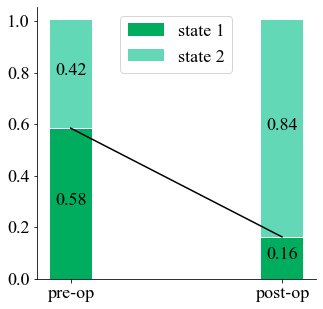

In [67]:
occupancy_rate = np.vstack((count_preop.sum(axis=0)/count_preop.sum(), count_postop.sum(axis=0)/count_postop.sum()))
fig, ax = plt.subplots(figsize=(5, 5))
bar_width = 0.2
rects = ax.bar(["pre-op", "post-op"], np.round(occupancy_rate[..., 0], 2), color="#00ad5f", width=bar_width, label="state 1")
ax.bar_label(rects, padding=3, label_type='center')
rects = ax.bar(["pre-op", "post-op"], np.round(occupancy_rate[..., 1], 2), color="#62d8b6", width=bar_width, bottom=occupancy_rate[..., 0], label="state 2")
ax.bar_label(rects, padding=3, label_type='center')
ax.plot(["pre-op", "post-op"], occupancy_rate[..., 0], color="black")
ax.legend(loc='upper center')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(f"{fig_dir}/occupancy.{fig_format}", dpi=300, format=fig_format, bbox_inches = "tight")

* 统计学检验
* statistics tests

In [ ]:
for i in range(k):
    stats_tests(dwell_time_preop[...,i], dwell_time_postop[...,i])
    print()

正态性检验preop:  0.07699902355670929
正态性检验postop:  0.883475661277771
方差齐性检验:  8.589372553098575e-05
非参数检验: 
Wilcoxon秩和检验:  2.3127826129219637 0.020734594207182492
曼-惠特尼U检验:  285.5 0.02142914754134848
ks检验:  0.55 0.00396729438660086
kruskal检验 5.353985915492982 0.02067495449226575

正态性检验preop:  0.00015776943473611027
正态性检验postop:  1.2961758329765871e-05
方差齐性检验:  0.03941308526463951
非参数检验: 
Wilcoxon秩和检验:  -3.2054355512427217 0.0013485824363168647
曼-惠特尼U检验:  81.5 0.0014089602377359222
ks检验:  0.6 0.001115801546231492
kruskal检验 10.28060352919092 0.0013443596579648333



In [ ]:
for i in range(k):
    stats_tests(occupancy_rate_preop[...,i], occupancy_rate_postop[...,i])
    print()

正态性检验preop:  0.014315475709736347
正态性检验postop:  0.13525420427322388
方差齐性检验:  9.082687819511987e-05
非参数检验: 
Wilcoxon秩和检验:  3.0701851060426066 0.0021392613957354222
曼-惠特尼U检验:  313.5 0.0022274911408885567
ks检验:  0.7 5.569062975843453e-05
kruskal检验 9.434887323943673 0.0021289616917650874

正态性检验preop:  0.014315405860543251
正态性检验postop:  0.1352553516626358
方差齐性检验:  9.082687819511987e-05
非参数检验: 
Wilcoxon秩和检验:  -3.0701851060426066 0.0021392613957354222
曼-惠特尼U检验:  86.5 0.0022274911408885567
ks检验:  0.7 5.569062975843453e-05
kruskal检验 9.434887323943673 0.0021289616917650874



In [ ]:
nonparametric.rank_compare_2indep(dwell_time_preop, dwell_time_postop)

<class 'statsmodels.stats.nonparametric.RankCompareResult'>
statistic = array([ 2.27401829, -4.01079871])
pvalue = array([0.03366902, 0.000274  ])
s1 = array([67.43355263, 22.69144737])
s2 = array([ 3.24934211, 20.95460526])
var1 = array([0.16858388, 0.05672862])
var2 = array([0.00812336, 0.05238651])
var = array([0.35341447, 0.21823026])
var_prob = array([0.00883536, 0.00545576])
nobs1 = 20
nobs2 = 20
nobs = 40
mean1 = array([24.775, 14.575])
mean2 = array([16.225, 26.425])
prob1 = array([0.71375, 0.20375])
prob2 = array([0.28625, 0.79625])
somersd1 = array([ 0.4275, -0.5925])
somersd2 = array([-0.4275,  0.5925])
df = array([20.82682012, 37.93992038])
use_t = True
tuple = (array([ 2.27401829, -4.01079871]), array([0.03366902, 0.000274  ]))

In [ ]:
nonparametric.rank_compare_2indep(occupancy_rate_preop, occupancy_rate_postop)

<class 'statsmodels.stats.nonparametric.RankCompareResult'>
statistic = array([ 3.24840966, -3.24840966])
pvalue = array([0.00406919, 0.00406919])
s1 = array([59.82302632, 59.82302632])
s2 = array([1.21776316, 1.21776316])
var1 = array([0.14955757, 0.14955757])
var2 = array([0.00304441, 0.00304441])
var = array([0.30520395, 0.30520395])
var_prob = array([0.0076301, 0.0076301])
nobs1 = 20
nobs2 = 20
nobs = 40
mean1 = array([26.175, 14.825])
mean2 = array([14.825, 26.175])
prob1 = array([0.78375, 0.21625])
prob2 = array([0.21625, 0.78375])
somersd1 = array([ 0.5675, -0.5675])
somersd2 = array([-0.5675,  0.5675])
df = array([19.77321118, 19.77321118])
use_t = True
tuple = (array([ 3.24840966, -3.24840966]), array([0.00406919, 0.00406919]))

对各个脑叶进行对比

In [5]:
with open("aal_translate.json", "r") as f:
    aal = json.load(f)
with open(f"states/total/cluster/km_60s_2states.pkl", "rb") as f:
    km = pickle.load(f)
centers = km.cluster_centers_.reshape((km.cluster_centers_.shape[0], 116, 116))
for fc in centers:
    np.fill_diagonal(fc, 0)
save_dir = "states/total/centroids"
with open(f"{save_dir}/centroids_preop.pkl", "rb") as f:
    centroids_preop = pickle.load(f)
with open(f"{save_dir}/centroids_postop.pkl", "rb") as f:
    centroids_postop = pickle.load(f)

In [3]:
lobes_name = ["Frontal", "Prefrontal", "Occipital", "Parietal", "Subcortical", "Temporal", "Cerebellum"]

In [4]:
lobes = {i:[] for i in lobes_name}
i = 0
for k in aal:
    # 合并Frontal和Prefrontal
    lobe = aal[k]["lobe"]
    if lobe == "Prefrontal":
        lobe = "Frontal"
    lobes[lobe].append(i)
    i += 1
# 移除Prefrontal
lobes.pop("Prefrontal")
with open("lobe.json", "w") as f:
    json.dump(lobes, f)

In [3]:
with open("lobe.json", "r") as f:
    lobes = json.load(f)
def cal_lobes_fc(lobe1, lobe2, fc):
    # 计算两个脑叶之间的平均相关性
    fc_sum = 0
    for i in lobes[lobe1]:
        for j in lobes[lobe2]:
            # fc_sum += fc[i][j]
            fc_sum += abs(fc[i][j])
    return fc_sum / ( len(lobes[lobe1]) * len(lobes[lobe2]) )
lobes_name = ["Frontal", "Occipital", "Parietal", "Subcortical", "Temporal", "Cerebellum"]
fig_dir = "states/total/figs"

In [6]:
lobes_preop = {i:{j:[] for j in lobes} for i in lobes}
lobes_postop = {i:{j:[] for j in lobes} for i in lobes}
lobes_states = {i:{j:[] for j in lobes} for i in lobes}
for lobe1 in lobes:
    for lobe2 in lobes:
        lobes_preop[lobe1][lobe2] = [cal_lobes_fc(lobe1, lobe2, centroids_preop[0]), cal_lobes_fc(lobe1, lobe2, centroids_preop[1])]
        lobes_postop[lobe1][lobe2] = [cal_lobes_fc(lobe1, lobe2, centroids_postop[0]), cal_lobes_fc(lobe1, lobe2, centroids_postop[1])]
        lobes_states[lobe1][lobe2] = [cal_lobes_fc(lobe1, lobe2, centers[0]), cal_lobes_fc(lobe1, lobe2, centers[1])]

In [7]:
fc1 = []
fc2 = []
for lobe1 in lobes:
    fc1.append([])
    fc2.append([])
    for lobe2 in lobes:
        fc1[-1].append(lobes_preop[lobe1][lobe2][0])
        fc2[-1].append(lobes_preop[lobe1][lobe2][1])
lobes_fc_preop = np.array([fc1, fc2])
fc1 = []
fc2 = []
for lobe1 in lobes:
    fc1.append([])
    fc2.append([])
    for lobe2 in lobes:
        fc1[-1].append(lobes_postop[lobe1][lobe2][0])
        fc2[-1].append(lobes_postop[lobe1][lobe2][1])
lobes_fc_postop = np.array([fc1, fc2])

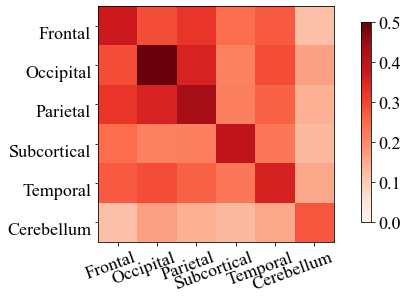

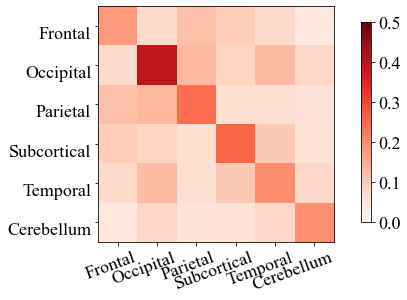

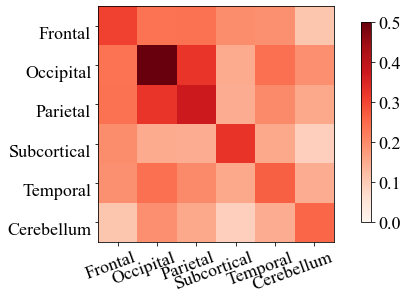

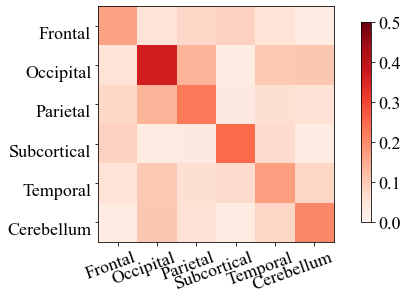

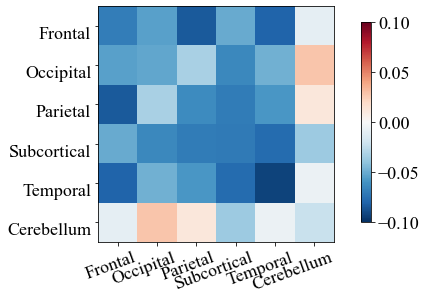

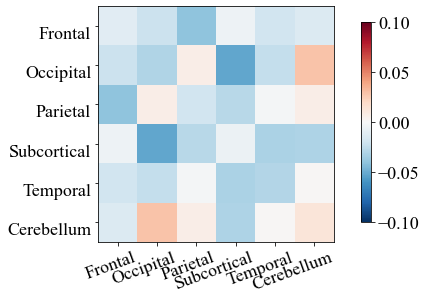

In [14]:
i = 0
for fc in lobes_fc_preop:
    i += 1
    lobes_display = plotting.plot_matrix(fc, labels=lobes_name, figure=(5, 5), colorbar=True, cmap="Reds", vmax=0.5, vmin=0)
    lobes_display.colorbar.ax.tick_params(labelsize=fontsize)
    fig_fc, ax_fc = lobes_display.figure, lobes_display.axes
    ax_fc.set_xticklabels(lobes_name, fontsize=fontsize, rotation=20)
    ax_fc.set_yticklabels(lobes_name, fontsize=fontsize, rotation=0)
    trans = mtrans.Affine2D().translate(20, 0)
    for t in ax_fc.get_xticklabels():
        t.set_transform(t.get_transform()+trans)
    if bg_color:
        fig_fc.patch.set_color(bg_color)
    fig_fc.savefig(f"{fig_dir}/lobes_preop_{i}.{fig_format}", format=fig_format, dpi=300, bbox_inches = 'tight')
i = 0
for fc in lobes_fc_postop:
    i += 1
    lobes_display = plotting.plot_matrix(fc, labels=lobes_name, figure=(5, 5), colorbar=True, cmap="Reds", vmax=0.5, vmin=0)
    lobes_display.colorbar.ax.tick_params(labelsize=fontsize)
    fig_fc, ax_fc = lobes_display.figure, lobes_display.axes
    ax_fc.set_xticklabels(lobes_name, fontsize=fontsize, rotation=20)
    ax_fc.set_yticklabels(lobes_name, fontsize=fontsize, rotation=0)
    trans = mtrans.Affine2D().translate(20, 0)
    for t in ax_fc.get_xticklabels():
        t.set_transform(t.get_transform()+trans)
    if bg_color:
        fig_fc.patch.set_color(bg_color)
    fig_fc.savefig(f"{fig_dir}/lobes_postop_{i}.{fig_format}", format=fig_format, dpi=300, bbox_inches = 'tight')
i = 0
for fc in (lobes_fc_postop - lobes_fc_preop):
    i += 1
    lobes_display = plotting.plot_matrix(fc, labels=lobes_name, figure=(5, 5), colorbar=True, vmax=0.1, vmin=-0.1)
    lobes_display.colorbar.ax.tick_params(labelsize=fontsize)
    fig_fc, ax_fc = lobes_display.figure, lobes_display.axes
    ax_fc.set_xticklabels(lobes_name, fontsize=fontsize, rotation=20)
    ax_fc.set_yticklabels(lobes_name, fontsize=fontsize, rotation=0)
    trans = mtrans.Affine2D().translate(20, 0)
    for t in ax_fc.get_xticklabels():
        t.set_transform(t.get_transform()+trans)
    if bg_color:
        fig_fc.patch.set_color(bg_color)
    fig_fc.savefig(f"{fig_dir}/lobes_change_{i}.{fig_format}", format=fig_format, dpi=300, bbox_inches = "tight")

In [13]:
lobes_fc_change = lobes_fc_postop - lobes_fc_preop

In [20]:
print(lobes_fc_preop)
print(lobes_fc_change)
print(lobes_fc_change/lobes_fc_preop)

[[[ 0.37   0.29   0.32   0.24   0.27   0.12 ]
  [ 0.29   0.57   0.35   0.21   0.29   0.17 ]
  [ 0.32   0.35   0.43   0.22   0.26   0.14 ]
  [ 0.24   0.21   0.22   0.40   0.23   0.13 ]
  [ 0.27   0.29   0.26   0.23   0.36   0.15 ]
  [ 0.12   0.17   0.14   0.13   0.15   0.28 ]]

 [[ 0.18   0.07   0.12   0.09   0.07   0.04 ]
  [ 0.07   0.39   0.13   0.08   0.12   0.08 ]
  [ 0.12   0.13   0.24   0.06   0.06   0.05 ]
  [ 0.09   0.08   0.06   0.25   0.10   0.06 ]
  [ 0.07   0.12   0.06   0.10   0.20   0.08 ]
  [ 0.04   0.08   0.05   0.06   0.08   0.19 ]]]
[[[ -0.07   -0.05   -0.08   -0.05   -0.08   -0.01 ]
  [ -0.05   -0.05   -0.03   -0.06   -0.05   0.03 ]
  [ -0.08   -0.03   -0.06   -0.07   -0.06   0.01 ]
  [ -0.05   -0.06   -0.07   -0.07   -0.08   -0.04 ]
  [ -0.08   -0.05   -0.06   -0.08   -0.09   -0.01 ]
  [ -0.01   0.03   0.01   -0.04   -0.01   -0.02 ]]

 [[ -0.01   -0.02   -0.04   -0.00   -0.02   -0.01 ]
  [ -0.02   -0.03   0.01   -0.05   -0.02   0.03 ]
  [ -0.04   0.01   -0.02   -0.03